# Анализ ROC кривых на аспиратах

In [1]:
import pandas as pd
import numpy as np
from math import floor
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from sklearn.model_selection import (LeaveOneOut, cross_val_score)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression

# Задача

Сравнить консистентность accuracy модели логистической регрессии в задаче классификации больных раком яичников и здоровых доноров.

In [3]:
orig_data = pd.read_excel('/content/test_results_trh_otx.xlsx')
orig_data = orig_data.query("tissue == 'aspirate'")
ca125_data = orig_data.query("mkb in ['C56', 'C57', 'N']",
                             engine='python')
ca125_data['BRCA'] = ca125_data['BRCA'].replace({'F': 0, 'wt': 0, 'T':1}).fillna(0)

<ipython-input-3-909990a1a7c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_data['BRCA'] = ca125_data['BRCA'].replace({'F': 0, 'wt': 0, 'T':1}).fillna(0)


## Подготовка данных

Заполним CA125 в нормах данными из [Factors Influencing Serum CA125II Levels in Healthy Postmenopausal Women](https://aacrjournals.org/cebp/article/10/5/489/253422/Factors-Influencing-Serum-CA125II-Levels-in) для белой популяции (17,852 женщин, часть из которых стали раковыми больными). Медиана CA125 14.2 Е/мл. 95% CI 6.0–41.0 Е/мл


Возраст 58.2 (40.9–60.2)

* Известно, что уровни CA125 нормализуют и приводят к нормальному распределнию, рассчитывая логарифм значений содержания белка.

* Для генерации значений СА125 будем использовать лог-нормальное распределение.

* Нам известны медиана и доверительный интервал значений СА125. Прологарифмируем их и приравняем медиану к среднему, чтобы рассчитать стандартное отклонение. Так как в статье среднее не указано.

* Стандартное отклонение найдем по [формуле](https://handbook-5-1.cochrane.org/chapter_7/7_7_3_3_obtaining_standard_deviations_from_standard_errors.htm):

$$ SE = (upCI - lowCI) / 3.92 $$

$$ SD = \sqrt{SE} $$

* Сгенерируем лог-нормальные значения и возведем их в экспоненциальную степень, чтобы избавиться от логарифма

In [4]:
mu = np.log(14.2)
se = np.log((41 - 6)) / 3.92
sd = se ** 0.5
samples = ca125_data.loc[ca125_data['CA125'].isna(), 'CA125'].shape[0]

In [5]:
rng = np.random.default_rng(42)
ca_values = rng.lognormal(mu, sd, samples)

Добавим сгенерированные значения СА125

In [6]:
ca125_data.loc[ca125_data['CA125'].isna(), 'CA125'] = ca_values

Прологарифмируем значения признаков для работы с линейной моделью.

In [7]:
ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']] += 0.01
ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']] = np.log(ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']])

<ipython-input-7-147653c04d5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']] += 0.01
<ipython-input-7-147653c04d5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']] = np.log(ca125_data[['OTX1', 'TRH', 'CA125', 'BRCA']])


Добавим столбец с классами

In [8]:
ca125_data['is_t'] = ca125_data['mkb'].apply(lambda row: 0 if row == 'N' else 1)

<ipython-input-8-edfa3c178cd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_data['is_t'] = ca125_data['mkb'].apply(lambda row: 0 if row == 'N' else 1)


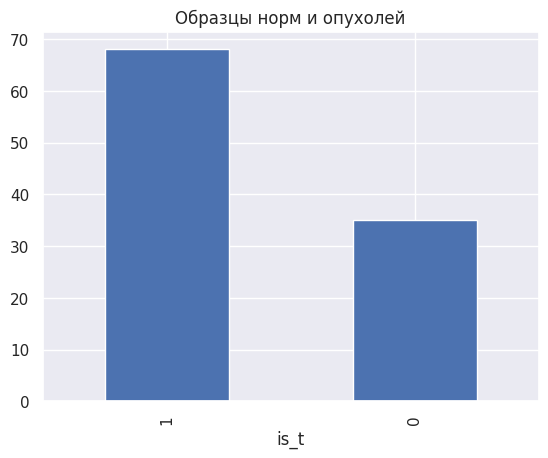

is_t
1    68
0    35
Name: count, dtype: int64

In [9]:
ca125_data['is_t'].value_counts().plot(kind='bar')
plt.title('Образцы норм и опухолей')
plt.show()
ca125_data['is_t'].value_counts()

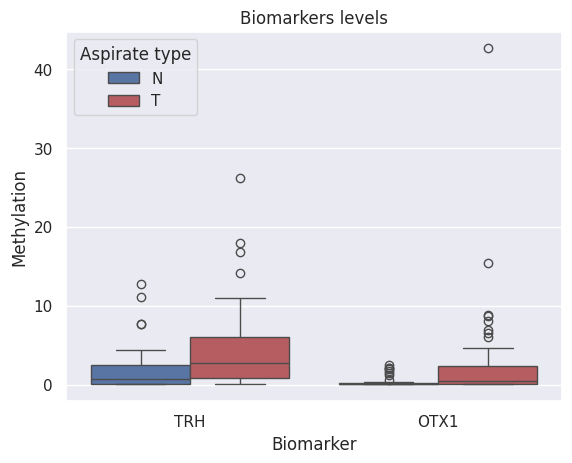

In [10]:
genes = ['OTX1', 'TRH', 'is_t']
palette = {'N': "b", 'T': "r"}

plot_data = np.exp(ca125_data[genes])
plot_data.loc[plot_data['is_t']==1, 'is_t'] = 'N'
plot_data.loc[plot_data['is_t']!='N', 'is_t'] = 'T'
plot_data = pd.melt(plot_data, value_vars=['TRH', 'OTX1', ], id_vars='is_t',
                    value_name='Methylation', var_name='Biomarker')
plot_data['Aspirate type'] = plot_data['is_t']

plt.title(f"Biomarkers levels")
ax = sns.boxplot(data=plot_data, x='Biomarker', y='Methylation', hue='Aspirate type',
              palette=palette
              )
plt.show()

## Так как мы используем моедль с малым числом образцов, мы проведем leave one out валидацию для того, чтобы оценить воспроизводимость ее работы

Подготовим данные

In [11]:
ca125_data.dropna(subset=['TRH', 'OTX1', 'CA125'], inplace=True)
ca125_data.set_index('id', inplace=True)
ca125_data.shape

<ipython-input-11-18da437284c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca125_data.dropna(subset=['TRH', 'OTX1', 'CA125'], inplace=True)


(97, 35)

Так как в нашей выборке нормальных образцов меньше, чем опухолевых, а метрика чувствительна к дисбалансу классов, мы проведем upsampling нормальных образцов методом SMOTE.

### 3 features

In [12]:
X = ca125_data[['TRH', 'OTX1', 'CA125']]
y = ca125_data['is_t']

In [13]:
%%time

# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

cv = LeaveOneOut()
# create model
model = LogisticRegression(random_state=42)
# evaluate model
scores_all = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_all), np.std(scores_all)))

Accuracy: 0.750 (0.433)
CPU times: user 260 ms, sys: 84.5 ms, total: 344 ms
Wall time: 3.24 s


### TRH

In [14]:
X = ca125_data[['TRH']]
y = ca125_data['is_t']

In [15]:
%%time

# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

cv = LeaveOneOut()
# create model
model = LogisticRegression(random_state=42)
# evaluate model
scores_trh = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_trh), np.std(scores_trh)))

Accuracy: 0.637 (0.481)
CPU times: user 112 ms, sys: 2.11 ms, total: 114 ms
Wall time: 751 ms


### OTX1

In [16]:
X = ca125_data[['OTX1']]
y = ca125_data['is_t']

In [17]:
%%time

# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

cv = LeaveOneOut()
# create model
model = LogisticRegression(random_state=42)
# evaluate model
scores_otx = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_otx), np.std(scores_otx)))

Accuracy: 0.694 (0.461)
CPU times: user 122 ms, sys: 4.96 ms, total: 127 ms
Wall time: 781 ms


# TRH+OTX1

In [18]:
X = ca125_data[["TRH", "OTX1"]]
y = ca125_data['is_t']

In [19]:
%%time

# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

cv = LeaveOneOut()
# create model
model = LogisticRegression(random_state=42)
# evaluate model
scores_trh_otx = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_trh_otx), np.std(scores_trh_otx)))

Accuracy: 0.694 (0.461)
CPU times: user 129 ms, sys: 2.56 ms, total: 132 ms
Wall time: 863 ms


### CA125

In [20]:
%%time
X = ca125_data[["CA125"]]
y = ca125_data['is_t']

# transform the dataset
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

cv = LeaveOneOut()
# create model
model = LogisticRegression(random_state=42)
# evaluate model
scores_ca = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores_ca), np.std(scores_ca)))

Accuracy: 0.766 (0.423)
CPU times: user 130 ms, sys: 5.89 ms, total: 136 ms
Wall time: 1.21 s


### Summary

,count,mean,std,min,25%,50%,75%,max
All,124.0,0.750000,0.434769,0.0,0.75,1.0,1.0,1.0
TRH,124.0,0.637097,0.482788,0.0,0.00,1.0,1.0,1.0
OTX1,124.0,0.693548,0.462890,0.0,0.00,1.0,1.0,1.0
TRH+OTX1,124.0,0.693548,0.462890,0.0,0.00,1.0,1.0,1.0
CA125,124.0,0.766129,0.425008,0.0,1.00,1.0,1.0,1.0


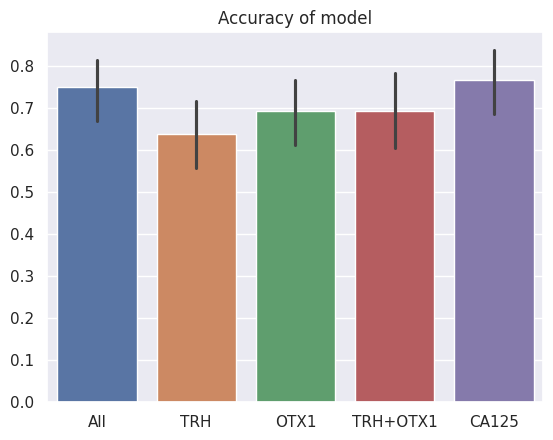

In [21]:
df = pd.DataFrame({"All":scores_all,
                   "TRH":scores_trh,
                   "OTX1":scores_otx,
                   "TRH":scores_trh,
                   "TRH+OTX1":scores_otx,
                   "CA125":scores_ca})

sns.barplot(df)
plt.title("Accuracy of model")
display(df.describe().T)

# Вывод

* Добавление признаков TRH и OTX1 не дает прироста в точности и стабильности работы модели.
* По отдельности признаки TRH и OTX1 работают хуже, чем CA125.